# Color classification model

The following Jupyter Notebooks showcases a color classification model, which was trained on white, red, green, "other" colors.

## Prerequisites
For executing the notebook, multiple packages are required. Additionally, the following package from this GitHub repo is required to run `summary(model,...)`
`$ pip install torchsummary` or `git clone https://github.com/sksq96/pytorch-summary`. This package is used to display the model in a similar way to Keras

The following packages are used in **ColorNeuralNet.py**:

In [1]:
import torch.nn as nn
import torchvision
from torch.utils.data import Dataset, DataLoader
############## TENSORBOARD ########################
from torch.utils.tensorboard import SummaryWriter
###################################################

############## CUSTOM PACKAGE #####################
from HelperFunctions.HelperPhases import *
###################################################

The custom package **HelperFunctions.HelperPhases** consists of the following imports:

In [2]:
import torch
from sklearn.metrics import confusion_matrix
import pandas as pd
import numpy as np
import seaborn as sn
from matplotlib import pyplot as plt
############## PROGESS BAR ########################
import sys
import time
###################################################

## Model
The model is trained with the HSL-Values of a color. For the color detection only the H and L Values from HSL are being used, because they are sufficient for simple color recognition.


In [3]:
from ColorNeuralNet import *

### model parameters
* `device`: device on which the tensors are being processed for example: "cuda", "cpu", "dml"
* `confusionmatrixdevice`: device on which the tensors are being processed for creating the confusionmatrix example: "cuda", "cpu", "dml"
* `all_classes`: list of all possible classes
* `DATASETFOLDER`: folder path of the dataset
* `TRAININGDATASETHLS`: path of the dataset file for training
* `TESTDATASETHLS`: path of the dataset file for training
* `MODELFOLDER`: folder path of the model. This model folder is used for loading and saving the trained model
* `hidden_size`: size of the first hidden layer of the model
* `num_epochs`: number of training epochs
* `batch_size`: number of color samples used per training/testing step
* `learning_rate`: base learning rate
* `load_model_from_file`: parameter to determine if the model should be loaded --> 1 == true & 0 == false
* `save_trained_model`: parameter to determine if the model should be saved --> 1 == true & 0 == false

#### default values used for this model

* The parameter `input_size = 2` can also be changed, but it requires a different dataset where all values of HSL are being used.
* The result of multiple tests with different `batch_size` values resulted in the following conclusion, that the value of `batch_size` needs to be equal or smaller than the classes to minimize overfitting. In this case I choose `batch_size = 4` to minimize overfitting and maximize the computation speed.
* The `hidden_size = 25` is the lowest possible value, which results in the highest possible accuracy from the given dataset.
* The parameter `learning_rate = 0.001` has this setting, because of the small differences between each dataset (examples further below).

In [4]:
# Devices
device = torch.device('cpu')
confusionmatrixdevice = torch.device('cpu')
# Classes
all_classes = ["white", "red", "green", "other"]
# Paths
DATASETFOLDER = './Datasets/'
TRAININGDATASETHLS = f"{DATASETFOLDER}TrainingDatasetHLS.txt"
TESTDATASETHLS = f"{DATASETFOLDER}TestDatasetHLS.txt"
MODELFOLDER = './Models/'
# Parameter
hidden_size = 25
num_classes = len(all_classes)
num_epochs = 10
batch_size = 4
learning_rate = 0.001

It is important to always check if `load_model_from_file` is set to `0` before training a model, otherwise a trained model could be overwritten

In [5]:
# 1 == True ; 0 == False
load_model_from_file = 0
save_trained_model = 0

If `save_trained_model` is set to `1` the user should check the following settings to **NOT** overwrite a trained model. The manual Filename setting should only be used for loading a trained model to minimize the risk of accidentally overwriting a trained model!

In [6]:
# Automatic Filename for loading and saving
learning_rate_string = str(learning_rate).replace('.', '')
MiddleFilename = f"HS{hidden_size}NE{num_epochs}BS{batch_size}LR{learning_rate_string}"
EndFilename = "HLS.pth"
FILE = f"{MODELFOLDER}ColorNeuralNet{MiddleFilename}{EndFilename}"

# Manuel Filename for loading
# FILE = "ColorNeuralNetHS25NE1500HLSACC8775.pth"
# FILE = "ColorNeuralNetHS25NE10BS10HLSACC9075.pth"

#### model creation
The model is created from my NeuralNet class with one hidden layer.

In [7]:
model = NeuralNet(input_size, hidden_size, num_classes).to(device)

#### criterion and optimizer
I chose the cross entropy loss function, because I have a model for multilabel classification. As an optimizer I used Adam, because it is one of the popular optimizer.
In the following code both can be changed to different ones:

In [8]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

#### training and test data loader
* If the dataset is not normalized `normalized = 0` then the data gets normalized inside the `dataloaderSetup` function. This feature can be used for BGR-Datasets but **NOT** for HSL-Datasets, because not every value of HSL has a max value of 255.

In [9]:
normalized = 1

train_loader = dataloaderSetup(TRAININGDATASETHLS, normalized)
test_loader = dataloaderSetup(TESTDATASETHLS, normalized)

### Input
The following output shows the size of each individual data:
The `hsl.size()` only contains the H and L Values, which results in an input size of 2.

In [10]:
hsl, label = next(iter(train_loader))
print(f"batch shape of hsl values: {hsl.size()}")
print(f"batch shape of labels: {label.size()}")

batch shape of hsl values: torch.Size([4, 2])
batch shape of labels: torch.Size([4, 1])


### Model summary

My color recognition model only has one hidden layer, because of the simplicity of simple color recognition. With my configurations I am only using the H- and L-Value to determine the color, which is also possible with an if-clause for every color. For the previous mentioned solution you need to manually configurate each value for each color, for example:
`if light_value > 229:
    return "WHITE"`
`elif hue_value < 5:
    return "RED"`

In [11]:
from torchsummary import summary

summary(model, input_size=(1,2))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                [-1, 1, 25]              75
              ReLU-2                [-1, 1, 25]               0
            Linear-3                 [-1, 1, 4]             104
Total params: 179
Trainable params: 179
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00
----------------------------------------------------------------


### Examples from the color dataset
The dataset was created by randomly generating a color with BGR-Values and manually determining which color class they belong to. After that each BGR-Value was transformed into an HSL-Value. The training dataset consists of **1600** color samples with **400** colors per class. The testing dataset consists of **400** color samples with **100** colors per class. Here are examples for each color from the TrainingDatasetHLS.
Here are four batches out of the dataset:

In [12]:
print("hsl: ([H,L])                 ; label:([class_id]); label as class: class_name")

for i, (hsl, labels) in enumerate(train_loader):
    if i == 4:
        break
    for j, (not_used) in enumerate(hsl):
        print(f"hsl:{hsl[j]} ; label:{labels[j]}; label as class: {all_classes[convertFloatTensorToLongTensor(labels[j])]}")

hsl: ([H,L])                 ; label:([class_id]); label as class: class_name
hsl:tensor([0.2251, 0.2725]) ; label:tensor([2.]); label as class: green
hsl:tensor([0.6788, 0.4216]) ; label:tensor([3.]); label as class: other
hsl:tensor([0.0556, 0.9412]) ; label:tensor([0.]); label as class: white
hsl:tensor([0.2333, 0.2098]) ; label:tensor([2.]); label as class: green
hsl:tensor([0.9470, 0.6137]) ; label:tensor([1.]); label as class: red
hsl:tensor([0.8092, 0.4667]) ; label:tensor([3.]); label as class: other
hsl:tensor([0.4030, 0.6275]) ; label:tensor([2.]); label as class: green
hsl:tensor([0.8868, 0.1647]) ; label:tensor([1.]); label as class: red
hsl:tensor([0.4787, 0.5686]) ; label:tensor([3.]); label as class: other
hsl:tensor([0.1849, 0.3961]) ; label:tensor([2.]); label as class: green
hsl:tensor([0.3819, 0.9412]) ; label:tensor([0.]); label as class: white
hsl:tensor([0.1889, 0.3569]) ; label:tensor([2.]); label as class: green
hsl:tensor([0.7215, 0.5471]) ; label:tensor([3.]);

## Both Phases

### Training phase
* `labels_start_at` is used if all labels start at 1 instead of 0
* `print_every_x_percent` states when the current accuracy and loss gets printed and the accuracy and loss graph are updated in tensor board

In the training phase of the model a progress bar with the remaining time as well as the accuracy and loss is displayed. After every epoch a confusion matrix is generated for tensor board as well as a plot visible in an output console.
Info: If the given color dataset is used, then `device="cpu"` is the fastest device for the confusion matrix as well as the training phase. This is the result of the color dataset being small enough.

Epoch [1/10], Step [40/400], Accuracy: 0.2188, Loss: 1.4112                                                  

Epoch [1/10], Step [80/400], Accuracy: 0.2938, Loss: 1.3131                                                  

Epoch [1/10], Step [120/400], Accuracy: 0.4375, Loss: 1.4008                                                  

Epoch [1/10], Step [160/400], Accuracy: 0.4750, Loss: 1.2980                                                  

Epoch [1/10], Step [200/400], Accuracy: 0.4000, Loss: 1.4685                                                  

Epoch [1/10], Step [240/400], Accuracy: 0.4813, Loss: 1.2138                                                  

Epoch [1/10], Step [280/400], Accuracy: 0.5437, Loss: 1.2300                                                  

Epoch [1/10], Step [320/400], Accuracy: 0.6000, Loss: 1.1937                                                  

Epoch [1/10], Step [360/400], Accuracy: 0.4875, Loss: 1.1762                                              

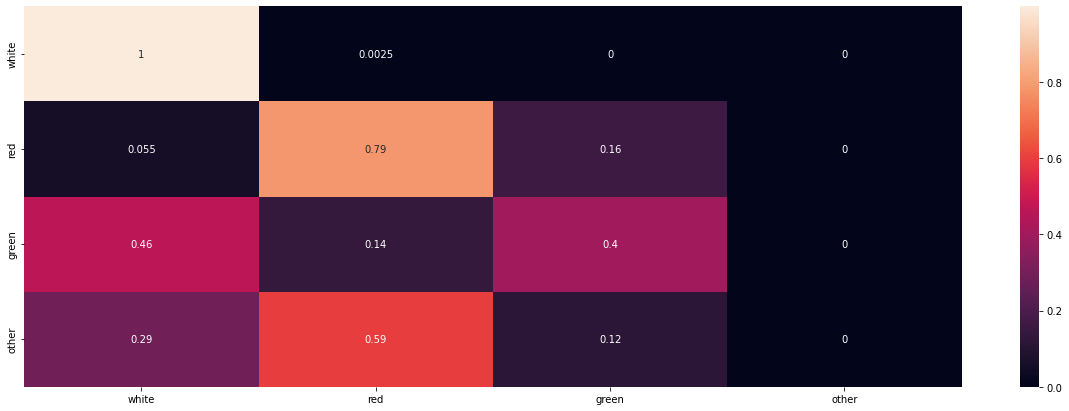


####################################Training Resumed#######################################

Epoch [2/10], Step [40/400], Accuracy: 0.5500, Loss: 1.4381                                                  

Epoch [2/10], Step [80/400], Accuracy: 0.6375, Loss: 1.0707                                                  

Epoch [2/10], Step [120/400], Accuracy: 0.6375, Loss: 1.2054                                                  

Epoch [2/10], Step [160/400], Accuracy: 0.6625, Loss: 1.1758                                                  

Epoch [2/10], Step [200/400], Accuracy: 0.6438, Loss: 0.8561                                                  

Epoch [2/10], Step [240/400], Accuracy: 0.6312, Loss: 1.3029                                                  

Epoch [2/10], Step [280/400], Accuracy: 0.6813, Loss: 0.9640                                                  

Epoch [2/10], Step [320/400], Accuracy: 0.6438, Loss: 1.2541                                                  

Epoch [2/10]

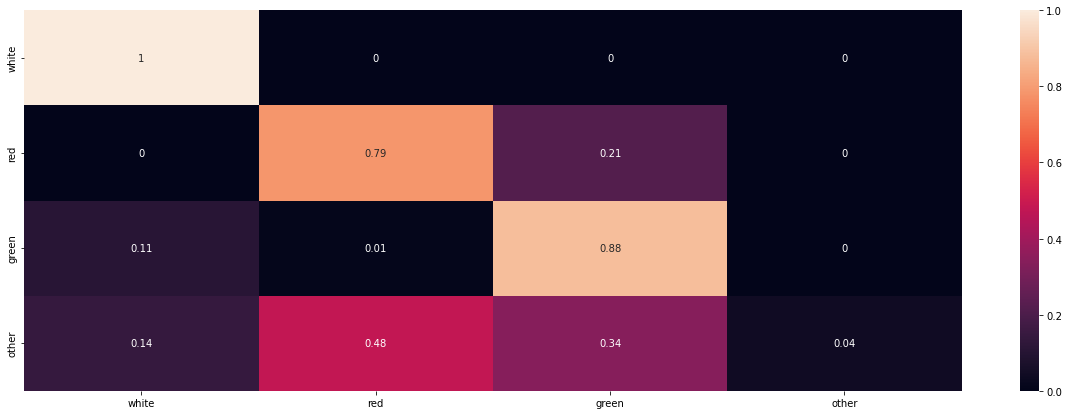


####################################Training Resumed#######################################

Epoch [3/10], Step [40/400], Accuracy: 0.6375, Loss: 1.2136                                                  

Epoch [3/10], Step [80/400], Accuracy: 0.6875, Loss: 0.7785                                                  

Epoch [3/10], Step [120/400], Accuracy: 0.7000, Loss: 1.1375                                                  

Epoch [3/10], Step [160/400], Accuracy: 0.6438, Loss: 0.7003                                                  

Epoch [3/10], Step [200/400], Accuracy: 0.6937, Loss: 0.7942                                                  

Epoch [3/10], Step [240/400], Accuracy: 0.6813, Loss: 1.3345                                                  

Epoch [3/10], Step [280/400], Accuracy: 0.7750, Loss: 0.7883                                                  

Epoch [3/10], Step [320/400], Accuracy: 0.7562, Loss: 0.5535                                                  

Epoch [3/10]

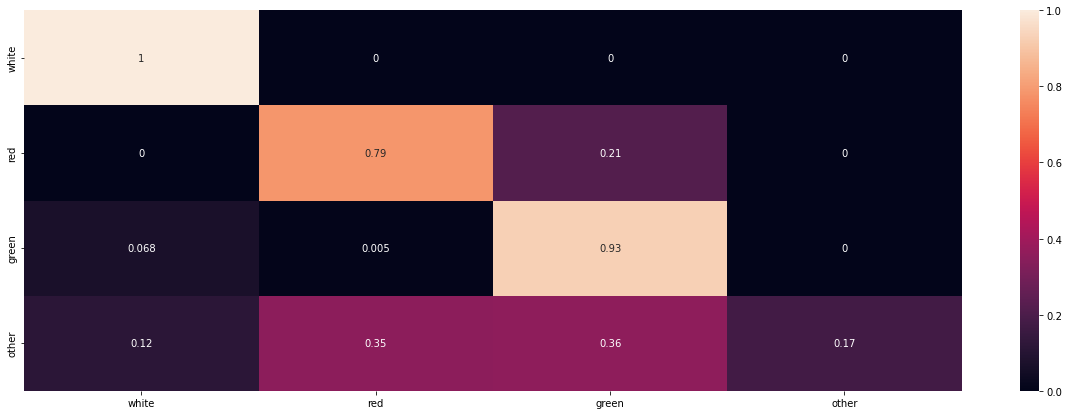


####################################Training Resumed#######################################

Epoch [4/10], Step [40/400], Accuracy: 0.7063, Loss: 0.6768                                                  

Epoch [4/10], Step [80/400], Accuracy: 0.7188, Loss: 0.8610                                                  

Epoch [4/10], Step [120/400], Accuracy: 0.7438, Loss: 0.7355                                                  

Epoch [4/10], Step [160/400], Accuracy: 0.7188, Loss: 0.5820                                                  

Epoch [4/10], Step [200/400], Accuracy: 0.7750, Loss: 0.6773                                                  

Epoch [4/10], Step [240/400], Accuracy: 0.7875, Loss: 0.8444                                                  

Epoch [4/10], Step [280/400], Accuracy: 0.6500, Loss: 0.7911                                                  

Epoch [4/10], Step [320/400], Accuracy: 0.7937, Loss: 0.4955                                                  

Epoch [4/10]

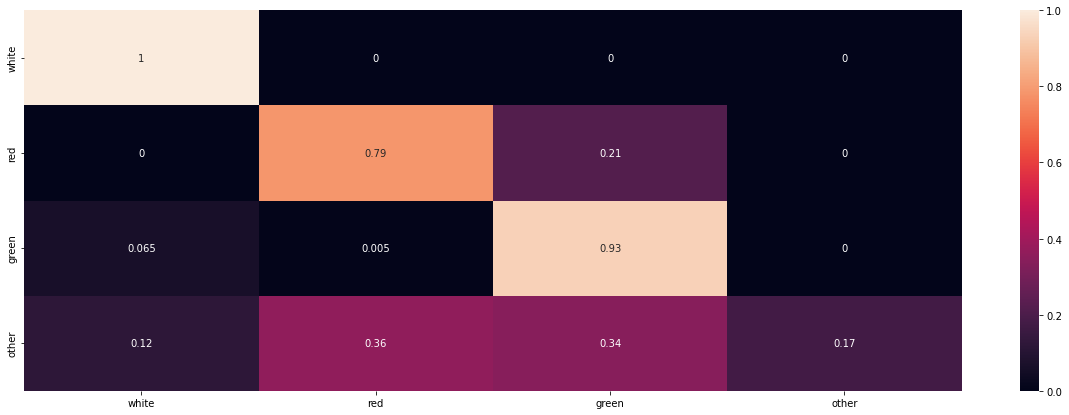


####################################Training Resumed#######################################

Epoch [5/10], Step [40/400], Accuracy: 0.7000, Loss: 0.9612                                                  

Epoch [5/10], Step [80/400], Accuracy: 0.7812, Loss: 0.6176                                                  

Epoch [5/10], Step [120/400], Accuracy: 0.7875, Loss: 0.6166                                                  

Epoch [5/10], Step [160/400], Accuracy: 0.7750, Loss: 0.6649                                                  

Epoch [5/10], Step [200/400], Accuracy: 0.7438, Loss: 0.8095                                                  

Epoch [5/10], Step [240/400], Accuracy: 0.7063, Loss: 0.3584                                                  

Epoch [5/10], Step [280/400], Accuracy: 0.7250, Loss: 0.6120                                                  

Epoch [5/10], Step [320/400], Accuracy: 0.7500, Loss: 0.6471                                                  

Epoch [5/10]

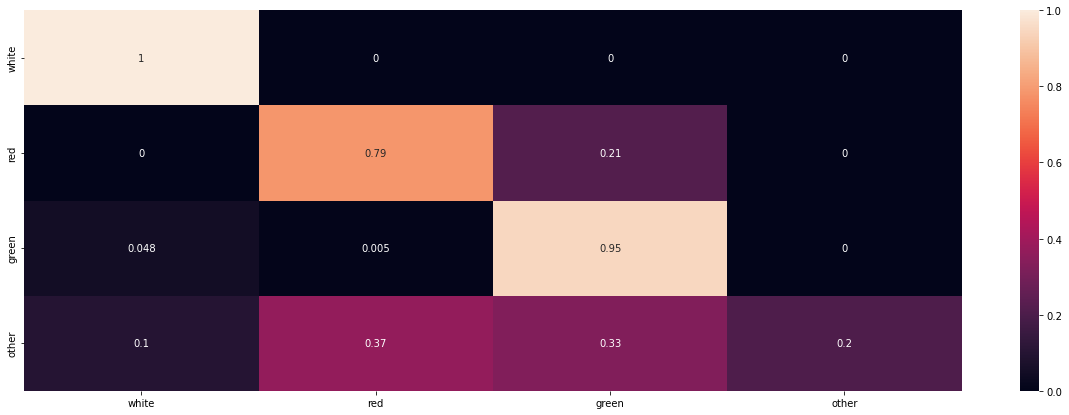


####################################Training Resumed#######################################

Epoch [6/10], Step [40/400], Accuracy: 0.7188, Loss: 0.9063                                                  

Epoch [6/10], Step [80/400], Accuracy: 0.7000, Loss: 0.8524                                                  

Epoch [6/10], Step [120/400], Accuracy: 0.7125, Loss: 0.3057                                                  

Epoch [6/10], Step [160/400], Accuracy: 0.7688, Loss: 0.5398                                                  

Epoch [6/10], Step [200/400], Accuracy: 0.7688, Loss: 0.7816                                                  

Epoch [6/10], Step [240/400], Accuracy: 0.7812, Loss: 0.3825                                                  

Epoch [6/10], Step [280/400], Accuracy: 0.7625, Loss: 1.4848                                                  

Epoch [6/10], Step [320/400], Accuracy: 0.7562, Loss: 1.1625                                                  

Epoch [6/10]

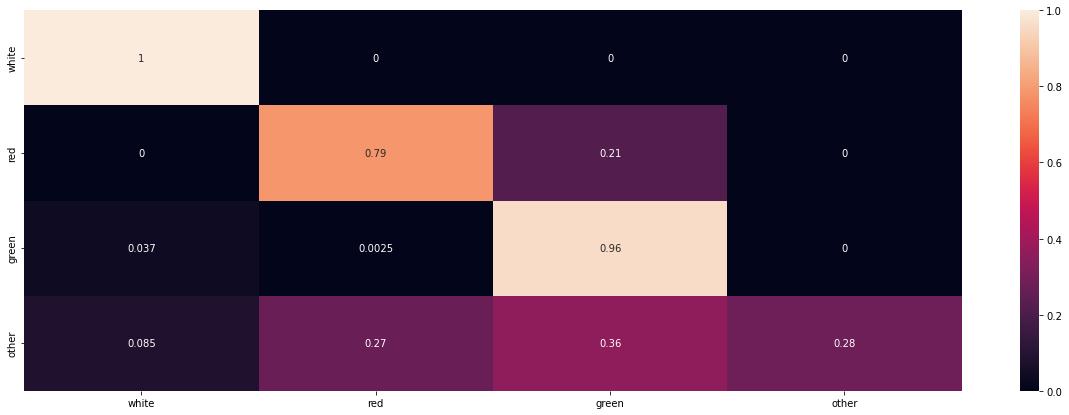


####################################Training Resumed#######################################

Epoch [7/10], Step [40/400], Accuracy: 0.7063, Loss: 0.5667                                                  

Epoch [7/10], Step [80/400], Accuracy: 0.7812, Loss: 0.8582                                                  

Epoch [7/10], Step [120/400], Accuracy: 0.7625, Loss: 0.5944                                                  

Epoch [7/10], Step [160/400], Accuracy: 0.7063, Loss: 0.5984                                                  

Epoch [7/10], Step [200/400], Accuracy: 0.7688, Loss: 0.4406                                                  

Epoch [7/10], Step [240/400], Accuracy: 0.7312, Loss: 0.9966                                                  

Epoch [7/10], Step [280/400], Accuracy: 0.8562, Loss: 0.3434                                                  

Epoch [7/10], Step [320/400], Accuracy: 0.7250, Loss: 0.5690                                                  

Epoch [7/10]

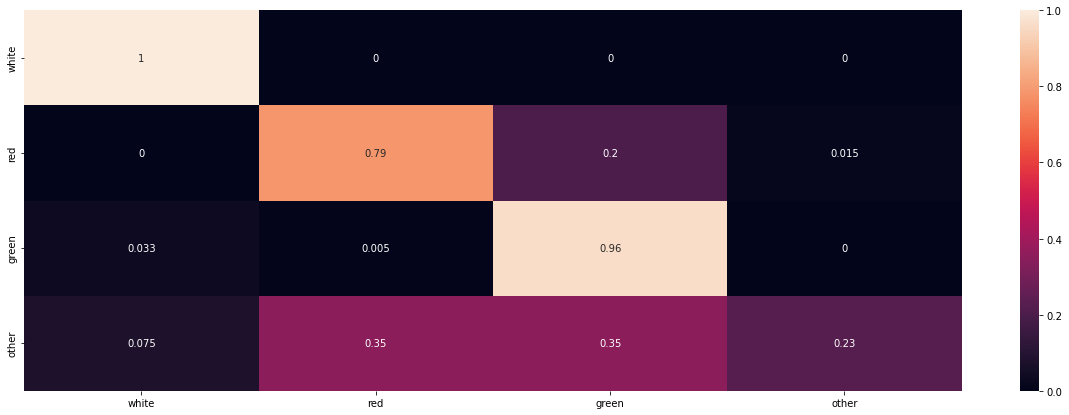


####################################Training Resumed#######################################

Epoch [8/10], Step [40/400], Accuracy: 0.7625, Loss: 0.4275                                                  

Epoch [8/10], Step [80/400], Accuracy: 0.7312, Loss: 0.2978                                                  

Epoch [8/10], Step [120/400], Accuracy: 0.7625, Loss: 0.2875                                                  

Epoch [8/10], Step [160/400], Accuracy: 0.7750, Loss: 0.4044                                                  

Epoch [8/10], Step [200/400], Accuracy: 0.7500, Loss: 0.4202                                                  

Epoch [8/10], Step [240/400], Accuracy: 0.8250, Loss: 0.3000                                                  

Epoch [8/10], Step [280/400], Accuracy: 0.8063, Loss: 0.4362                                                  

Epoch [8/10], Step [320/400], Accuracy: 0.7125, Loss: 0.6353                                                  

Epoch [8/10]

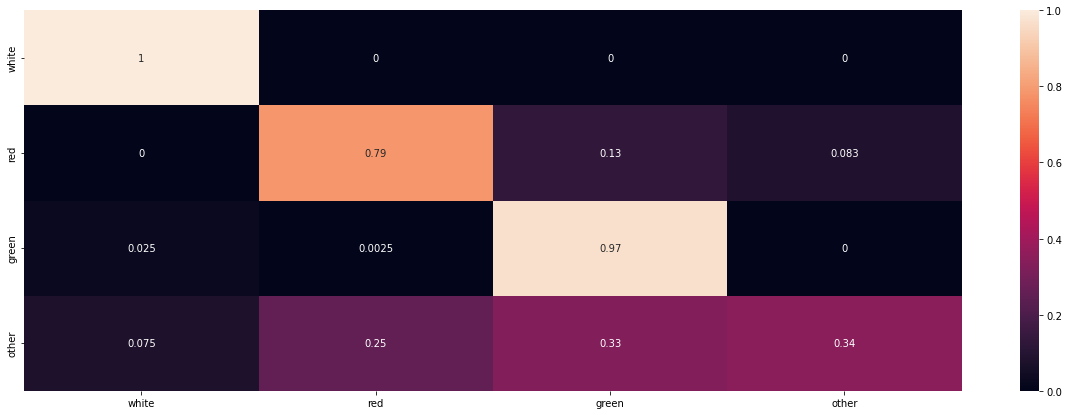


####################################Training Resumed#######################################

Epoch [9/10], Step [40/400], Accuracy: 0.8000, Loss: 0.3920                                                  

Epoch [9/10], Step [80/400], Accuracy: 0.7812, Loss: 0.3765                                                  

Epoch [9/10], Step [120/400], Accuracy: 0.7750, Loss: 0.8368                                                  

Epoch [9/10], Step [160/400], Accuracy: 0.8313, Loss: 0.9382                                                  

Epoch [9/10], Step [200/400], Accuracy: 0.7562, Loss: 1.0862                                                  

Epoch [9/10], Step [240/400], Accuracy: 0.7688, Loss: 0.7635                                                  

Epoch [9/10], Step [280/400], Accuracy: 0.8250, Loss: 0.5900                                                  

Epoch [9/10], Step [320/400], Accuracy: 0.7750, Loss: 0.3675                                                  

Epoch [9/10]

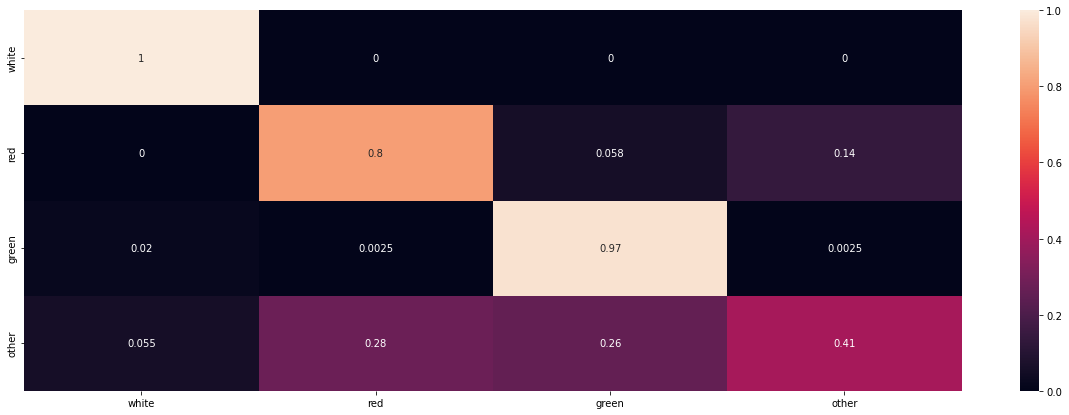


####################################Training Resumed#######################################

Epoch [10/10], Step [40/400], Accuracy: 0.8187, Loss: 0.6874                                                  

Epoch [10/10], Step [80/400], Accuracy: 0.8313, Loss: 0.4112                                                  

Epoch [10/10], Step [120/400], Accuracy: 0.8187, Loss: 0.3788                                                  

Epoch [10/10], Step [160/400], Accuracy: 0.8000, Loss: 0.5804                                                  

Epoch [10/10], Step [200/400], Accuracy: 0.7875, Loss: 0.5493                                                  

Epoch [10/10], Step [240/400], Accuracy: 0.7875, Loss: 0.8826                                                  

Epoch [10/10], Step [280/400], Accuracy: 0.7875, Loss: 0.4975                                                  

Epoch [10/10], Step [320/400], Accuracy: 0.8313, Loss: 0.4526                                                  

Epoc

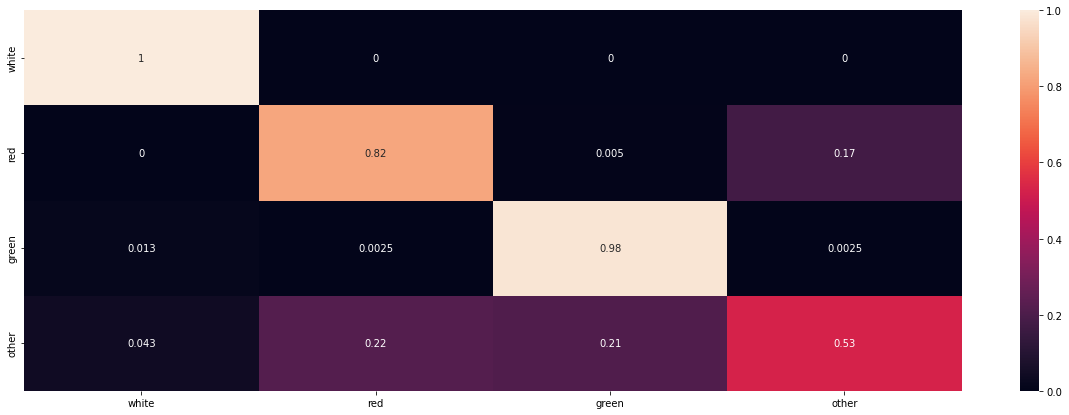

In [13]:
labels_start_at = 0
print_every_x_percent = 0.1

model = trainingPhase(model, criterion, optimizer, train_loader, num_epochs, print_every_x_percent, save_trained_model, device, confusionmatrixdevice, writer, FILE, all_classes, labels_start_at)

### Testing phase
* `output_examples_check` is used to determine if an output should be given for displaying all false guessed batches by the model

In the testing phase of the model a progress bar with the remaining time is displayed. At the end a confusion matrix is generated for tensor board as well as a plot visible in the outputs.



Starting with Testing!

Creating Confusion Matrix ...
[███████████████████████████████████████████████████████████-] 99.0% ...remaining Time: 0.0s



#####################################Statistics############################################

Accuracy of the network on white: 94.0 % (94/100)

Accuracy of the network on red: 68.0 % (68/100)

Accuracy of the network on green: 95.0 % (95/100)

Accuracy of the network on other: 55.0 % (55/100)

Accuracy of the network on all: 78.0 % (312/400)



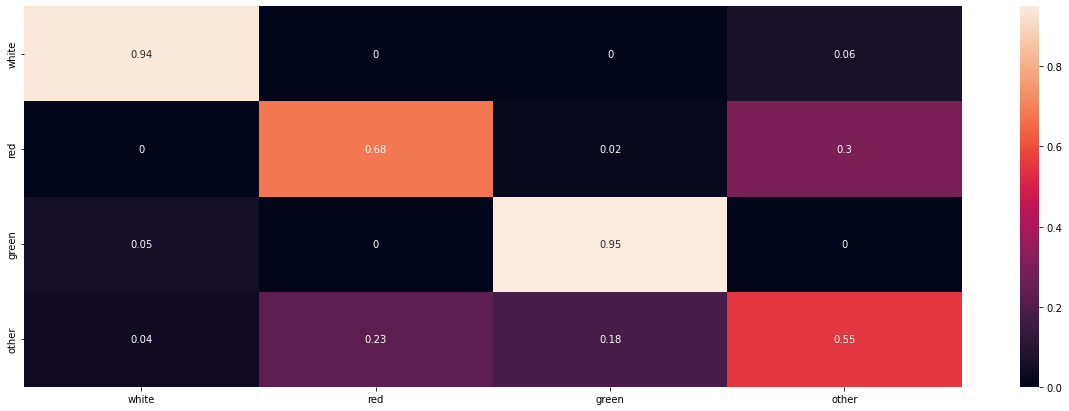

In [15]:
output_examples_check = 0

testingPhase(model, test_loader, writer, FILE, all_classes, labels_start_at, confusionmatrixdevice, output_examples_check)